<a href="https://colab.research.google.com/github/QiuBingCheng/computer-vision-learning-notes/blob/main/FirstPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Project
Quickly train a model to understand some of PyTorch's basic building blocks to train a deep learning model.

## Import module

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## Import The Data

In [8]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Exploring the Data

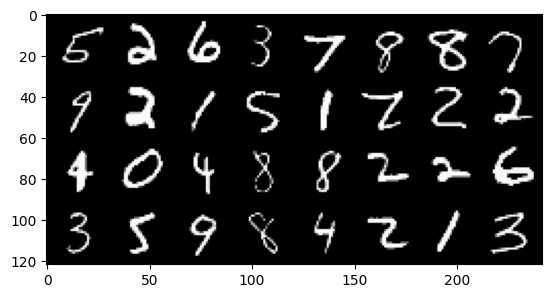

In [10]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## get some random training images
for images, labels in trainloader:
  break

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch

In [11]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## The Model

In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [13]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## Training the Model

In [14]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [16]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6492 | Train Accuracy: 81.46
Epoch: 1 | Loss: 1.4929 | Train Accuracy: 97.07
Epoch: 2 | Loss: 1.4837 | Train Accuracy: 97.94
Epoch: 3 | Loss: 1.4802 | Train Accuracy: 98.24
Epoch: 4 | Loss: 1.4769 | Train Accuracy: 98.59


Compute accuracy on the testing dataset

In [17]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.05
